In [1]:
import numpy as np
from ple import PLE
from ple.games.catcher import Catcher
import time
import pandas as pd
import matplotlib.pyplot as plt

couldn't import doomish
Couldn't import doom


In [2]:
class LearningAgent:

    def __init__(self, actions, param_dict):
        self.actions = actions
        self.learning_rate = param_dict['learning_rate']
        self.discount_factor = param_dict['discount_factor']
        self.exploration_rate = param_dict['exploration_rate']
        self.exploration_decay = param_dict['exploration_decay']
        self.last_update_episode = 0

        self.prev_state = None
        self.prev_action = None

        # select number of discrete states for every state characteristic
        self.num_discrete_states = 4

        # initialize ranges for state characteristics
        self.boundaries = {
            'player_x': [20, 60],
            'player_vel': [-4, 4],
            'fruit_x': [20, 80],
            'fruit_y': [30, 90]
        }

        self.discrete_states = {
            'player_x': np.linspace(self.boundaries['player_x'][0], self.boundaries['player_x'][1],
                                    self.num_discrete_states - 1),
            'player_vel': np.linspace(self.boundaries['player_vel'][0], self.boundaries['player_vel'][1],
                                      self.num_discrete_states - 1),
            'fruit_x': np.linspace(self.boundaries['fruit_x'][0], self.boundaries['fruit_x'][1],
                                   self.num_discrete_states - 1),
            'fruit_y': np.linspace(self.boundaries['fruit_y'][0], self.boundaries['fruit_y'][1],
                                   self.num_discrete_states - 1)
        }

        self.q = self.q_init()

    # initialize q_table and fill it with zeros
    def q_init(self):
        q = {}
        for i in range(self.num_discrete_states):
            for j in range(self.num_discrete_states):
                for k in range(self.num_discrete_states):
                    for l in range(self.num_discrete_states):
                        q[str(i) + str(j) + str(k) + str(l)] = {
                            self.actions[0]: 0,
                            self.actions[1]: 0,
                            self.actions[2]: 0
                        }
        return q

    # for continuous observations find discrete state
    def build_state(self, obs):
        player_x = str(np.digitize(obs['player_x'], self.discrete_states['player_x']))
        player_vel = str(np.digitize(obs['player_vel'], self.discrete_states['player_vel']))
        fruit_x = str(np.digitize(obs['fruit_x'], self.discrete_states['fruit_x']))
        fruit_y = str(np.digitize(obs['fruit_y'], self.discrete_states['fruit_y']))

        return player_x + player_vel + fruit_x + fruit_y

    def pick_action(self, reward, obs, episode):
        # make update
        state = self.build_state(obs)

        if self.prev_state != None:
             self.q[self.prev_state][self.prev_action] += self.learning_rate * (reward +
                       self.discount_factor * self.q[state][max(self.q[state],key=self.q[state].get)] -
                       self.q[self.prev_state][ self.prev_action])

                
        # decrease exploration rate every N episodes
        if (((episode+1) % 200 == 0) and ((episode+1) > self.last_update_episode)):
            self.last_update_episode = episode+1
            self.exploration_rate *= self.exploration_decay
            
        
        # select best action
        enable_exploration = (1 - self.exploration_rate) <= np.random.uniform(0, 1)
        if enable_exploration:
            action = self.actions[np.random.randint(0, len(self.actions))]
        else:
            action = max(self.q[state], key=self.q[state].get)

        self.prev_state = state
        self.prev_action = action
        return action

In [3]:
# experiment parameters
params = {
    'learning_rate': 0.1,
    'discount_factor': 0.9,
    'exploration_rate': 0.5,
    'exploration_decay': 0.9,
    'episodes': 20000,
    'max_timestamps': 500
}

# initialize game
game = Catcher(width=100, height=100, init_lives=1)
p = PLE(game, fps=30, frame_skip=3, num_steps=1, force_fps=True, display_screen=False)
p.init()

# initialize agent
agent = LearningAgent(p.getActionSet(), params)

# track training time
start_time = time.time()

# write logs
logs = {'episode': [],
        'avg_timestamp_last_200_episodes': [],
        'exploration_rate': []}

# run training
reward = 0.0
episodes = params['episodes']
max_timestamps = params['max_timestamps']
episode_results = []

for episode_index in range(episodes):
    p.reset_game()

    for timestamp in range(max_timestamps):
        observation = game.getGameState()
        action = agent.pick_action(reward, observation, episode_index)
        reward = p.act(action)

        if p.game_over():
            break

    episode_results.append(timestamp+1)
    
    # print training 
    if (episode_index + 1) % 500 == 0:
        avg_timestamps = np.mean(episode_results[len(episode_results)-500:])
        print('Episode %4d Timestamps: %3d, Exploration rate: %.3f' % 
              (episode_index+1, avg_timestamps, agent.exploration_rate))
        
    # write logs
    mean_timestamp = np.mean(episode_results[len(episode_results)-200:])
    logs['episode'].append(episode_index+1)
    logs['avg_timestamp_last_200_episodes'].append(mean_timestamp)
    logs['exploration_rate'].append(agent.exploration_rate)
    
    # convergence condition
    if mean_timestamp >= 200:
        print('Early stopping. Average timestamp over last 200 episodes is %3d'%(mean_timestamp))
        break
    
print('\n Training time: %.1f minutes' % ((time.time() - start_time)/60))

Episode  500 Timestamps:  23, Exploration rate: 0.405
Episode 1000 Timestamps:  34, Exploration rate: 0.295
Episode 1500 Timestamps:  39, Exploration rate: 0.239
Episode 2000 Timestamps:  42, Exploration rate: 0.174
Episode 2500 Timestamps:  44, Exploration rate: 0.141
Episode 3000 Timestamps:  54, Exploration rate: 0.103
Episode 3500 Timestamps:  61, Exploration rate: 0.083
Episode 4000 Timestamps:  71, Exploration rate: 0.061
Episode 4500 Timestamps:  86, Exploration rate: 0.049
Episode 5000 Timestamps:  65, Exploration rate: 0.036
Episode 5500 Timestamps:  62, Exploration rate: 0.029
Episode 6000 Timestamps:  79, Exploration rate: 0.021
Episode 6500 Timestamps:  87, Exploration rate: 0.017
Episode 7000 Timestamps:  76, Exploration rate: 0.013
Episode 7500 Timestamps:  88, Exploration rate: 0.010
Episode 8000 Timestamps:  93, Exploration rate: 0.007
Episode 8500 Timestamps: 102, Exploration rate: 0.006
Episode 9000 Timestamps: 143, Exploration rate: 0.004
Episode 9500 Timestamps: 168

In [4]:
# save model
np.save('../model/q_table.npy', agent.q)
np.save('../model/q_table_descrete_states.npy', agent.discrete_states)

# save logs
logs = pd.DataFrame(logs)
logs = logs[['episode','avg_timestamp_last_200_episodes','exploration_rate']]
logs.to_csv('../logs/q_learning_logs.csv', index=False)

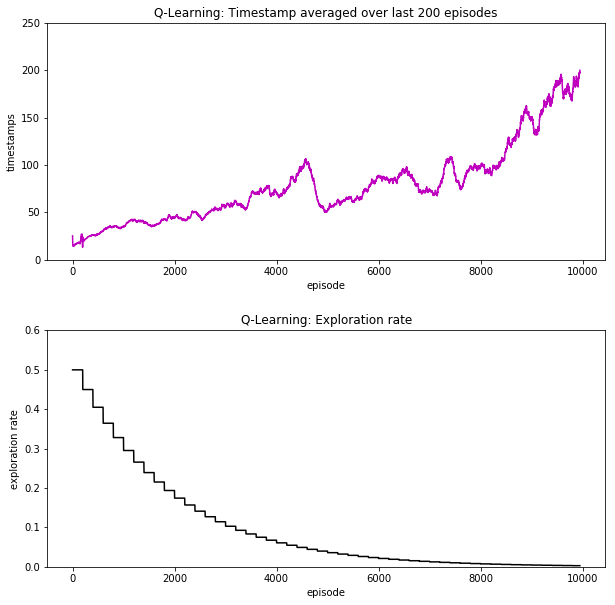

In [5]:
plt.figure(figsize=[10,10])
plt.subplots_adjust(hspace=0.3)

plt.subplot(2,1,1)
plt.plot(logs['episode'], logs['avg_timestamp_last_200_episodes'], 'm')
plt.title('Q-Learning: Timestamp averaged over last 200 episodes')
plt.ylabel('timestamps')
plt.xlabel('episode')
plt.ylim([0, 250])

plt.subplot(2,1,2)
plt.plot(logs['episode'], logs['exploration_rate'], 'k')
plt.title('Q-Learning: Exploration rate')
plt.ylabel('exploration rate')
plt.xlabel('episode')
plt.ylim([0,0.6])

plt.savefig('../figure/plot/q_learning_plot.jpg')
plt.show()
